# Phase One Project UPDATE

### Where to open a new flower shop... in Silver Spring, Maryland or Leesburg, Virginia?

## Imports

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import folium

## Yelp API Call

In [3]:
# Prep API key
with open('api_key.txt') as f:
    lines = f.read()

In [4]:
# Yelp API convention
url = 'https://api.yelp.com/v3/businesses/search'
key = lines
headers = {
    'Authorization': 'Bearer %s' % key
}

In [5]:
# Pull raw search data from Yelp for Silver Spring, MD (50 at a time)
data = []
for offset in range(0, 1000, 50):
    url_params = {
        'term': "flower",
        'location': 'Silver Spring+MD',
        'limit': 50,
        'offset': offset,
        "radius": 8047
    }

    response = requests.get(url, headers=headers, params=url_params)
    if response.status_code == 200:
        data += response.json()['businesses']

    elif response.status_code == 400:
            print('400 Bad Request')
            break

In [6]:
# Pull raw search data from Yelp for Leesburg, VA (50 at a time)
data2 = []
for offset in range(0, 1000, 50):
    url_params = {
        'term': "flower",
        'location': 'Leesburg+VA',
        'limit': 50,
        'offset': offset,
        "radius": 8047
    }

    response = requests.get(url, headers=headers, params=url_params)
    if response.status_code == 200:
        data2 += response.json()['businesses']

    elif response.status_code == 400:
            print('400 Bad Request')
            break

## Clean Yelp Results

In [7]:
# Function to clean raw Yelp data
def getbiz(params):
    names = []
    ratings = []
    pricing = []
    cnt = []
    address = []
    is_closed = []
    review_count = []
    categories = []
    city = []
    distance = []
    longitude = []
    latitude = []

    for i in range(len(params)):
        names.append(params[i]['name'])
        ratings.append(params[i]['rating'])
        address.append((params[i]['location']['address1']))
        is_closed.append(params[i]['is_closed'])
        review_count.append(params[i]['review_count'])
        categories.append(params[i]['categories'])
        city.append(params[i]['location']['city'])
        distance.append(params[i]['distance'])
        longitude.append(params[i]['coordinates']['longitude'])
        latitude.append(params[i]['coordinates']['latitude'])
        try:
            [pricing.append(len(params[i]['price']))]
        except:
            pricing.append(None)
        cnt.append(params[i]['review_count'])
    biz = {'name': names, 'rating': ratings, 'pricing': pricing, 'num_reviews': cnt, 'street_address': address, 
            'is_closed': is_closed, 'review_count': review_count, 'categories': categories, 'city': city,
            'distance': distance, 'longitude': longitude, 'latitude': latitude}


    return pd.DataFrame(biz)

In [8]:
# Clean results
ssdf = getbiz(data)
lbdf = getbiz(data2)

In [9]:
# Delete shops that are not within the respective cities (Yelp search results included 'serviced areas'...)
ssdf = ssdf[ssdf.city == 'Silver Spring']
lbdf = lbdf[lbdf.city == 'Leesburg']

In [10]:
# Add new ordered index and drop out of order one post clean
ssdf.reset_index(inplace = True)
ssdf.drop('index', 1, inplace= True)

In [11]:
# Add new ordered index and drop out of order one post clean
lbdf.reset_index(inplace = True)
lbdf.drop('index', 1, inplace= True)

In [12]:
#Save cleaned data to CSV
ssdf.to_csv('silver_spring.csv', encoding='utf-8', index=False)

lbdf.to_csv('leesburg.csv', encoding='utf-8', index=False)

In [13]:
# Seperate alias from list to better filter out non-flower shops 
def find_alias(params):
    alias = []
    for i in range(len(params)):
        alias.append(params['categories'][i][0]['alias'])
       # if params['categories'][i][0]['alias'] == '':
        #    df.drop(params['categories'][i])
    params['alias'] = alias

In [14]:
# Run for Silver Spring df
find_alias(ssdf)

In [15]:
#Find and delete empty category which prevents function from running
lbdf = lbdf.dropna(subset=['categories'])

In [16]:
#Find and destroy empty list which prevents function from running
lbdf = lbdf[lbdf['categories'].map(lambda d: len(d)) > 0]

In [17]:
# Run for Silver Spring df
find_alias(lbdf)

In [19]:
#Function to filter non-flowershops
def flower_filter(params):
    indexNames = params[(params['alias'] != 'florists') & (params['alias'] != 'floraldesigners') ].index
    params.drop(indexNames, inplace=True)
    return params

In [20]:
lbdf = flower_filter(lbdf)
ssdf = flower_filter(ssdf)

In [21]:
ssdf

,name,rating,pricing,num_reviews,street_address,is_closed,review_count,categories,city,distance,longitude,latitude,alias
0,"Bell Flowers, Inc.",5.0,2.0,70,8947 Brookville Rd,False,70,"[{'alias': 'florists', 'title': 'Florists'}]",Silver Spring,2972.202721,-77.052067,39.003009,florists
1,Danisa's Wholesale Fresh Flowers Inc,4.5,2.0,27,8870 Monard Dr,False,27,"[{'alias': 'florists', 'title': 'Florists'}]",Silver Spring,3567.895819,-77.059157,39.001541,florists
2,Potomac Floral Wholesale,3.5,2.0,76,2403 Linden Ln,False,76,"[{'alias': 'florists', 'title': 'Florists'}, {...",Silver Spring,3155.302144,-77.050338,39.009649,florists
3,Garden Vivien,5.0,NaN,1,2223 Kansas Ave,False,1,"[{'alias': 'florists', 'title': 'Florists'}]",Silver Spring,2721.772142,-77.049093,39.003290,florists
5,Da Vinci's Florist,4.0,2.0,37,2756 Garfield Ave,False,37,"[{'alias': 'florists', 'title': 'Florists'}, {...",Silver Spring,3451.436878,-77.057779,39.001881,florists
6,Creative Floral Designs,3.5,2.0,27,12158 Tech Rd,False,27,"[{'alias': 'florists', 'title': 'Florists'}, {...",Silver Spring,7528.587951,-76.967169,39.054732,florists
8,Ella's Florals,5.0,NaN,4,None,False,4,"[{'alias': 'florists', 'title': 'Florists'}]",Silver Spring,5007.226265,-77.028870,38.996680,florists
9,Roxana Multiservices,3.0,NaN,6,8727 Flower Ave,False,6,"[{'alias': 'floraldesigners', 'title': 'Floral...",Silver Spring,1238.291097,-77.003873,38.999579,floraldesigners
10,Citiflowers,2.5,NaN,11,2321 Stewart Ave,False,11,"[{'alias': 'florists', 'title': 'Florists'}, {...",Silver Spring,2826.536441,-77.050319,39.002958,florists
13,Sweet Stems Floral,5.0,NaN,2,3020 Beethoven Way,False,2,"[{'alias': 'floraldesigners', 'title': 'Floral...",Silver Spring,9928.829936,-76.945920,39.069223,floraldesigners


In [22]:
lbdf

,name,rating,pricing,num_reviews,street_address,is_closed,review_count,categories,city,distance,longitude,latitude,alias
0,Loudoun D Floral,4.5,2.0,16,,False,16,"[{'alias': 'florists', 'title': 'Florists'}]",Leesburg,1491.759497,-77.534730,39.130220,florists
1,J Morris Flowers,4.0,3.0,27,120 East Market St,False,27,"[{'alias': 'florists', 'title': 'Florists'}]",Leesburg,1314.094845,-77.561445,39.114299,florists
2,CPK Floral Designs,5.0,NaN,10,None,False,10,"[{'alias': 'florists', 'title': 'Florists'}, {...",Leesburg,1491.759497,-77.531944,39.119907,florists
3,Jerry's Flowers & Gifts,4.0,2.0,22,700 Fieldstone Dr NE,False,22,"[{'alias': 'florists', 'title': 'Florists'}]",Leesburg,1147.831498,-77.545801,39.125919,florists
4,Springvale Floral,5.0,NaN,4,None,False,4,"[{'alias': 'floraldesigners', 'title': 'Floral...",Leesburg,1491.759497,-77.569520,39.112050,floraldesigners
5,House Of Redman,5.0,NaN,1,206 Loudoun St SW,False,1,"[{'alias': 'florists', 'title': 'Florists'}, {...",Leesburg,1858.989002,-77.567840,39.115130,florists
6,Holly Heider Chapple Flowers,4.0,NaN,3,None,False,3,"[{'alias': 'florists', 'title': 'Florists'}]",Leesburg,1491.759497,-77.566540,39.108480,florists
8,Wild Green Yonder,5.0,NaN,2,106 Loudoun St SW,False,2,"[{'alias': 'floraldesigners', 'title': 'Floral...",Leesburg,1773.476827,-77.566845,39.114899,floraldesigners
11,Affordable Arrangements,5.0,NaN,2,,False,2,"[{'alias': 'floraldesigners', 'title': 'Floral...",Leesburg,1491.759497,-77.569405,39.110386,floraldesigners


## Analysis

In [23]:
# Pull basic info on df
ssdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 13
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            10 non-null     object 
 1   rating          10 non-null     float64
 2   pricing         5 non-null      float64
 3   num_reviews     10 non-null     int64  
 4   street_address  9 non-null      object 
 5   is_closed       10 non-null     bool   
 6   review_count    10 non-null     int64  
 7   categories      10 non-null     object 
 8   city            10 non-null     object 
 9   distance        10 non-null     float64
 10  longitude       10 non-null     float64
 11  latitude        10 non-null     float64
 12  alias           10 non-null     object 
dtypes: bool(1), float64(5), int64(2), object(5)
memory usage: 1.0+ KB


In [24]:
# Pull basic info on df
lbdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 0 to 11
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9 non-null      object 
 1   rating          9 non-null      float64
 2   pricing         3 non-null      float64
 3   num_reviews     9 non-null      int64  
 4   street_address  6 non-null      object 
 5   is_closed       9 non-null      bool   
 6   review_count    9 non-null      int64  
 7   categories      9 non-null      object 
 8   city            9 non-null      object 
 9   distance        9 non-null      float64
 10  longitude       9 non-null      float64
 11  latitude        9 non-null      float64
 12  alias           9 non-null      object 
dtypes: bool(1), float64(5), int64(2), object(5)
memory usage: 945.0+ bytes


Text(0, 0.5, 'Percentage')

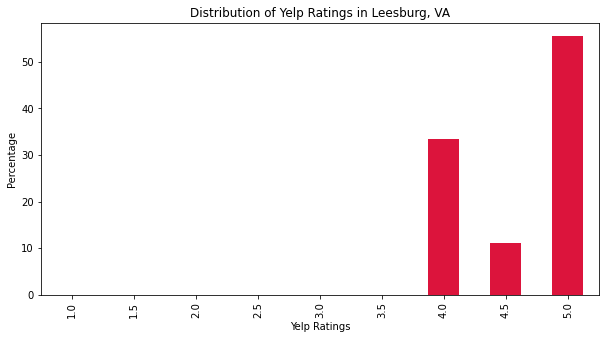

In [25]:
# Plot distribution of Yelp Ratings by Percentage
lbdf.rating.value_counts(normalize = True).mul(100).reindex([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]).plot(kind="bar", figsize = (10,5), color = "crimson")
plt.title("Distribution of Yelp Ratings in Leesburg, VA")
plt.xlabel("Yelp Ratings")
plt.ylabel("Percentage")

Text(0, 0.5, 'Percentage')

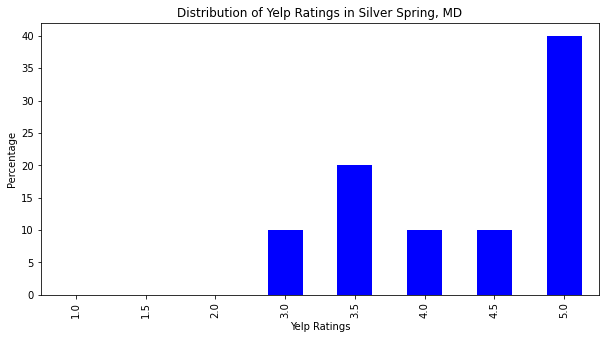

In [26]:
# Plot distribution of Yelp Ratings by Percentage
ssdf.rating.value_counts(normalize = True).mul(100).reindex([1, 1.5, 2, 3, 3.5, 4, 4.5, 5]).plot(kind="bar", figsize = (10,5), color = "blue")
plt.title("Distribution of Yelp Ratings in Silver Spring, MD")
plt.xlabel("Yelp Ratings")
plt.ylabel("Percentage")

Text(0, 0.5, 'Review Count')

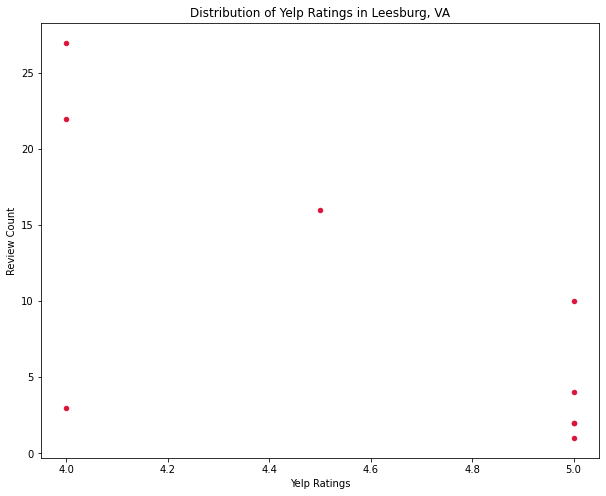

In [27]:
# Plot distribution of Yelp Ratings by count
lbdf.plot.scatter("rating", "num_reviews", figsize = (10,8), color = "crimson") 
plt.title("Distribution of Yelp Ratings in Leesburg, VA")
plt.xlabel("Yelp Ratings")
plt.ylabel("Review Count")

Text(0, 0.5, 'Review Count')

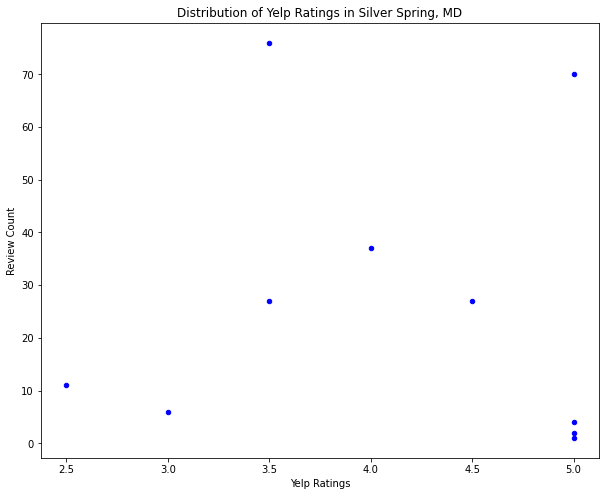

In [28]:
# Plot distribution of Yelp Ratings by count
ssdf.plot.scatter("rating", "num_reviews", figsize = (10,8), color = "blue") 
plt.title("Distribution of Yelp Ratings in Silver Spring, MD")
plt.xlabel("Yelp Ratings")
plt.ylabel("Review Count")

In [29]:
# Create variable for Census csv
census_ss = open('Census_SS.csv')
census_ss

<_io.TextIOWrapper name='Census_SS.csv' mode='r' encoding='cp1252'>

In [30]:
# Silver Spring population from US Census B.
ss_lst = open('Census_SS.csv').readlines()
ss_lst[4]

'"Population, Census, April 1, 2020","","81,015",""\n'

In [31]:
# Leesburg population from US Census B.
lb_lst = open('Census_LB.csv').readlines()
lb_lst[1]

'"Population estimates, July 1, 2019,  (V2019)","","53,727",""\n'

In [52]:
# Flower shop per capita Silver Spring
per_cap_ss = 81015 // len(ssdf.name)
print(per_cap_ss, "flower shops per capita in Silver Spring, MD")

8101 flower shops per capita in Silver Spring, MD


In [56]:
# Flower shop per capita Leesburg
per_cap_lb = 53727 // len(lbdf.name)
print(per_cap_lb, "flower shops per capita in Leesburg, VA")

5969 flower shops per capita in Leesburg, VA


In [57]:
# Average income from Silver Spring
ss_lst[46]

'"Per capita income in past 12 months (in 2019 dollars), 2015-2019","","$43,920",""\n'

In [58]:
# Average income from Leesburg
lb_lst[46]

'"Per capita income in past 12 months (in 2019 dollars), 2015-2019","","$48,427",""\n'

In [67]:
# Average age from each city
print("Leesburg, VA:", lb_lst[8], lb_lst[7], lb_lst[6])

Leesburg, VA: "Persons 65 years and over, percent","","8.5%",""
 "Persons under 18 years, percent","","26.7%",""
 "Persons under 5 years, percent","","6.5%",""



In [68]:
print("Silver Spring, MD:", ss_lst[8], ss_lst[7], ss_lst[6])

Silver Spring, MD: "Persons 65 years and over, percent","","10.4%",""
 "Persons under 18 years, percent","","22.4%",""
 "Persons under 5 years, percent","","8.0%",""



## Maps

In [53]:


map_ss = folium.Map(location=[38.90, -77.03], zoom_start=10)
ssdf.apply(lambda row:folium.CircleMarker(location=[row["latitude"], 
                                                  row["longitude"]]).add_to(map_ss),
     axis=1)

lbdf.apply(lambda row:folium.CircleMarker(location=[row["latitude"],
                                                  row["longitude"]], color="crimson").add_to(map_ss),
     axis=1)



map_ss